In [1]:
import numpy as np
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd
import glob
import pickle
import os

RUNS_PATH = 'runs/'

EVOLUTION_PATH = RUNS_PATH + 'evolution_cee_shapes_features_pop_size_16_cull_interval_5000_cull_rate_0.25_e64_h64_len5_voc5_evo_mode_best'
CE_BEST_PATH = RUNS_PATH + 'cee_shapes_features_pop_size_16_cull_interval_5000_cull_rate_0.25_e64_h64_len5_voc5_cull_mode_best'

In [2]:
#get best sender/receiver paths for cee (evo and ce) from EVOLUTION_PATH and CE_PATH

def get_best_agent(population, att='acc', min_mode=False):
    """
    Helper function that goes though a list of agents and returns the one with highest mean accuracy
    """
    best_val = 0.0 if not min_mode else 100.0
    best_a = 0
    for i, agent in enumerate(population):
        val = getattr(agent, att)
        if type(val) is list:
            val = mean(val)
        if (best_val < val and not min_mode) or (best_val > val and min_mode):
            best_a = i
            best_val = val
    return population[best_a]


def get_best_agents(folder_path, single_pool=False, **kwargs):
    # read cee.p files and go through agent attributes for one with highest val acc
    cee_files = glob.glob(folder_path+'*/*/cee.p')
    best_receivers = []
    best_senders = []
    for cee_file in cee_files:
        cee = pickle.load(open(cee_file, 'rb'))
        if single_pool:
            best_agent = get_best_agent(cee.agents, **kwargs)
            best_senders.append(best_agent)
            best_receivers.append(best_agent)
        else:
            best_senders.append(get_best_agent(cee.senders, **kwargs))
            best_receivers.append(get_best_agent(cee.receivers, **kwargs))
    
    best_sender = get_best_agent(best_senders)
    best_receiver = get_best_agent(best_receivers)
    
    return (best_sender, best_receiver)

evo_sender, evo_receiver = get_best_agents(EVOLUTION_PATH)
ce_best_sender, ce_best_receiver = get_best_agents(CE_BEST_PATH)

In [3]:
#get 'best' baseline sender/receiver by pretraining
from baseline import baseline

# Run baseline model 
params = ['--iterations', '1000', '--log-interval', '500']
model_name = baseline(params)
baseline_sender_filename = model_name+'/sender.p'
baseline_receiver_filename = model_name+'/receiver.p'

----------------------------------------
Model name: shapes_features_e_64_h_64_lr_0.001_max_len_5_k_3_vocab_5_seed_42_btch_size_1024 
|V|: 5
L: 5
ShapesSender(
  (input_module): ShapesMetaVisualModule(
    (process_input): Linear(in_features=512, out_features=64, bias=True)
  )
  (rnn): LSTMCell(64, 64)
  (linear_out): Linear(in_features=64, out_features=5, bias=True)
)
ShapesReceiver(
  (input_module): ShapesMetaVisualModule(
    (process_input): Linear(in_features=64, out_features=512, bias=True)
  )
  (rnn): LSTMCell(64, 64)
)
Total number of parameters: 133637
0/1000 Iterations: val loss: 3.272349089384079, val accuracy: 0.248046875
500/1000 Iterations: val loss: 0.17158290185034275, val accuracy: 0.9373779296875
1000/1000 Iterations: val loss: 0.08626966550946236, val accuracy: 0.966796875
Test accuracy: 0.9669971955128205


### Baseline experiments (freezing either sender or receiver) 
Here we test the effect of the different sender or receiver models obtained from CE / Evolution / Baseline (2 agent setup) in transferring the knowledge to a newly initialized basline LSTM model. 


In [4]:
def get_metrics_from_folders(folder_paths):
    """
    Helper function to get metrics from list of experiment folders, and return as whole
    """
    results = {}
    for i, f_path in enumerate(folder_paths):
        results[i] = {}
        saved_metrics = glob.glob("{}/metrics*.p".format(f_path))
        for m in saved_metrics:
            iteration = int(m.split("_")[-1].split(".")[0])
            p=pickle.load(open(m, 'rb'))
            results[i][iteration] = p
    return results

def plot_metric(results, metrics=["avg_convergence"], ylabel=None, show_error=True, savefig=False, figname=None):
    
    ci = 'sd' if show_error else None
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    
    run_names = []
    metric_names = []
    iterations = []
    values = []
    
    for m in metrics:
        for r in list(results.keys()):
            for s in list(results[r].keys()):
                for iteration_number in sorted(list(results[r][s].keys())):
                    if iteration_number == 0:
                        continue
                    iterations.append(iteration_number)
                    values.append(results[r][s][iteration_number][m])
                    run_names.append(r)
                    metric_names.append(m)
            
    values = np.array(values)
    iterations = np.array(iterations)        
    if len(metrics) < 2:     
        d = {'Number of Iterations': iterations, m: values, 'run_name': run_names, 'metric_name': metric_names}
        ax = sns.lineplot(ax=ax, x='Number of Iterations', y=m, data=pd.DataFrame(data=d), style='run_name', hue='run_name', ci=ci)
        if ylabel is None:
            ylabel = m
    else:
        d = {'Number of Iterations': iterations, 'val': values, 'run_name': run_names, 'metric_name': metric_names}
        ax = sns.lineplot(ax=ax, x='Number of Iterations', y='val', data=pd.DataFrame(data=d), style="metric_name", hue="run_name", ci=ci)
        if ylabel is None:
            ylabel = "val"
        
    ax.set(xlabel='Number of Iterations', ylabel=ylabel)
    if savefig:
        if figname is None:
            figname = ylabel
        plt.savefig(RELATIVE_PATH+figname)
        
    plt.show()

In [12]:
# sample 10 different baseline (LSTM) receiver models

def run_sender_experiments(sender_model=None, freeze=True, num_receivers=10, exp_name='baseline'):
    seeds = list(range(num_receivers))
    folders = []
    for s in tqdm_notebook(seeds):
        params =['--iterations', '5000', '--log-interval', '50',
                 '--disable-print','--name', '{}_{}'.format(exp_name, s),
                 '--folder', 'sender_experiments', '--seed', str(s)]

        if sender_model is not None:
            params += ['--sender-path', sender_model]
        if freeze:
            params += ['--freeze-sender']
            
        folder = baseline(params)
        folders.append(folder)
    return get_metrics_from_folders(folders)

# train with frozen baseline_sender, best_evo_sender, best_ce_sender, and from scratch

# run_sender_experiments()
results = {}
results['baseline'] = run_sender_experiments(freeze=False)
results['baseline_pretrained'] = run_sender_experiments(sender_model=baseline_sender_filename, exp_name='baseline_pretrained')
results['evolution'] = run_sender_experiments(sender_model=evo_sender.filename, exp_name="evolution")
results['ce_best'] = run_sender_experiments(sender_model=ce_best_sender.filename, exp_name="ce_best")

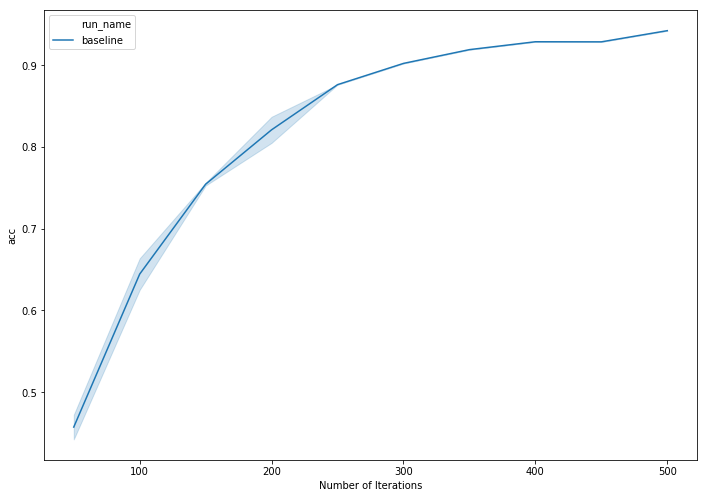

In [24]:
plot_metric(results, metrics=['acc'], show_error=True)

### sample 10 different baseline (LSTM) sender models:

train with frozen baseline_receiver, best_evo_receiver, best_ce_receiver, and from scratch

get_all_folder_names (plot results)
